In [20]:
from gem.models import CNN
from gem.utils import *
from gem.datasets import NPDataset
from torchinfo import summary
import Levenshtein
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
import torch
from torch import utils
from torch import nn
from torch import optim
import tqdm
set_seed(41)
device = "cuda:0"

def train(model, train_loader,test_loader,patience=3,epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
    # optimizer = optim.Adam(model.parameters(), lr=0.0033, betas=(0.9, 0.999), eps=3.43e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30)
    early_stopping = EarlyStopping(patience=patience)
    lst, vlst = [],[]
    for epoch in range(epochs):
        model.train()
        train_epoch_loss=[]
        for idx, (x, y) in tqdm.tqdm(enumerate(train_loader)):
            outputs = model(x.to(device))
            optimizer.zero_grad()
            loss = criterion(y.to(device), outputs)
            loss.backward()
            train_epoch_loss.append(loss.detach().item())
            optimizer.step()
            # scheduler.step()
        train_loss = np.average(train_epoch_loss)
        valid_epoch_loss = []
        model.eval()
        for idx, (data_x, data_y) in enumerate(test_loader):
            outputs = model(data_x.to(device))
            loss = criterion(data_y.to(device), outputs)
            valid_epoch_loss.append(loss.detach().item())
        valid_loss = np.average(valid_epoch_loss)
        print("epoch={}/{} of train, train loss={}, valid loss={}".format(epoch + 1, epochs,train_loss, valid_loss))
        lst.append(train_loss)
        vlst.append(valid_loss)

        if early_stopping.early_stop(model,valid_loss):
            break
    return early_stopping.best_model,pd.DataFrame(data={"loss":lst,"val_loss":vlst})

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    # Make predictions
    model.eval()
    predictions = model(torch.tensor(test_seq,dtype=torch.float).to(device)).reshape(-1,1).cpu().detach().numpy()
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


original_seq = 'atgggcggcgcatgagagaagcccagaccaattacctacccaaa'
original_seq=original_seq.upper()
name,seq_len,suff = "exp12-merge",118,"" # _seq exp12-merge pl3-1-2
datadir=f"/data/home/jinyalong/data/sev_241110/results/{name}/{name}_"
e_train = pd.read_csv(f"{datadir}train{suff}.csv")
e_test= pd.read_csv(f"{datadir}test{suff}.csv")
e_train['distance'] = e_train.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
e_test['distance'] = e_test.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
# e_train["score"] = e_train['score_final']
# e_test["score"] = e_test['score_final']
print(e_train.shape, e_test.shape )
label="score"
batch_size= 64 # 64, 256
kernel_size = 5
set_seed(41)
train_x = one_hot_encode(e_train,seq_len=seq_len)
test_x = one_hot_encode(e_test, seq_len=seq_len)
test_y = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
tran_y = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
dataset_train = NPDataset(train_x,tran_y)
dataset_test = NPDataset(test_x,test_y)
train_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
test_loader = utils.data.DataLoader(dataset_test, batch_size=batch_size)
model = CNN(seq_len=seq_len,kernel_size=kernel_size)
model = model.to(device)
model,pdf=train(model, train_loader, test_loader,patience=10,epochs=50) # 10,50
# model = torch.load(f"./models/{name}.pt")
test_data(df=e_test, model=model, obs_col=label,test_seq=test_x)
r = r2(e_test['pred'],e_test["score"])
pr =  stats.pearsonr(e_test['pred'],e_test["score"] )
print(f'test {name} r-squared = ', r, "pearsonR = ", pr[0])
torch.save(model,f"./models/{name}-{kernel_size}.pt")

(12007, 6) (1335, 6)


188it [00:00, 231.45it/s]


epoch=1/50 of train, train loss=0.8985372195218472, valid loss=0.6154186541125888


188it [00:00, 268.45it/s]


epoch=2/50 of train, train loss=0.6704837809851829, valid loss=0.5569415262767247


188it [00:00, 268.31it/s]


epoch=3/50 of train, train loss=0.6064355641286424, valid loss=0.5335379952476138


188it [00:00, 266.58it/s]


epoch=4/50 of train, train loss=0.5733779985853966, valid loss=0.5025916653020042


188it [00:00, 270.85it/s]


epoch=5/50 of train, train loss=0.5593585847540105, valid loss=0.4526458503234954


188it [00:00, 270.47it/s]


epoch=6/50 of train, train loss=0.5515856765052105, valid loss=0.5114745511895135


188it [00:00, 270.17it/s]


epoch=7/50 of train, train loss=0.5524848460199985, valid loss=0.4752950214204334


188it [00:00, 233.05it/s]


epoch=8/50 of train, train loss=0.5406791940331459, valid loss=0.45177284876505536


188it [00:00, 204.49it/s]


epoch=9/50 of train, train loss=0.5540070736661871, valid loss=0.44844257831573486


188it [00:00, 234.14it/s]


epoch=10/50 of train, train loss=0.5434743064515134, valid loss=0.43940575917561847


188it [00:00, 217.61it/s]


epoch=11/50 of train, train loss=0.5387753714272316, valid loss=0.4365355046022506


188it [00:00, 193.75it/s]


epoch=12/50 of train, train loss=0.5392709058967042, valid loss=0.4356880358287266


188it [00:00, 198.47it/s]


epoch=13/50 of train, train loss=0.5318658580171302, valid loss=0.44260255921454655


188it [00:00, 206.81it/s]


epoch=14/50 of train, train loss=0.5365076946451309, valid loss=0.44129095049131484


188it [00:00, 200.91it/s]


epoch=15/50 of train, train loss=0.523199475826101, valid loss=0.43521709527288166


188it [00:00, 216.64it/s]


epoch=16/50 of train, train loss=0.5243475884199142, valid loss=0.42338204241934274


188it [00:00, 217.00it/s]


epoch=17/50 of train, train loss=0.49778755833493904, valid loss=0.441525148493903


188it [00:00, 217.10it/s]


epoch=18/50 of train, train loss=0.5036776761742349, valid loss=0.4221253650529044


188it [00:00, 215.96it/s]


epoch=19/50 of train, train loss=0.49470877599843005, valid loss=0.419803343358494


188it [00:00, 218.80it/s]


epoch=20/50 of train, train loss=0.4950974236460442, valid loss=0.42844216028849286


188it [00:00, 219.12it/s]


epoch=21/50 of train, train loss=0.49335944763523465, valid loss=0.4546986995708375


188it [00:00, 209.22it/s]


epoch=22/50 of train, train loss=0.5005524838541416, valid loss=0.4339670971745536


188it [00:00, 205.39it/s]


epoch=23/50 of train, train loss=0.4939026428346938, valid loss=0.4213069450287592


188it [00:00, 217.58it/s]


epoch=24/50 of train, train loss=0.48825219749136173, valid loss=0.4348875255811782


188it [00:00, 219.24it/s]


epoch=25/50 of train, train loss=0.4911617012100017, valid loss=0.4598654167992728


188it [00:00, 218.90it/s]


epoch=26/50 of train, train loss=0.49062838024915534, valid loss=0.4552378938311622


188it [00:00, 200.19it/s]


epoch=27/50 of train, train loss=0.49393769417037353, valid loss=0.43984141094344004


188it [00:00, 197.34it/s]


epoch=28/50 of train, train loss=0.48099224348651604, valid loss=0.4708518087863922


188it [00:00, 198.44it/s]

epoch=29/50 of train, train loss=0.4678400111325244, valid loss=0.4276973988328661
test exp12-merge r-squared =  0.5823839775831353 pearsonR =  0.7631408635259516


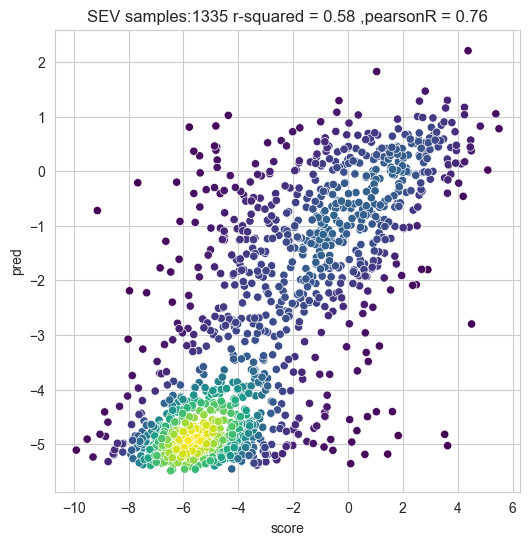

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sdf=e_test
num=len(sdf)
name = name.split("_")[0] if "_"in name else "SEV"
values = np.vstack([sdf["score"], sdf['pred']])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
plt.title(f"{name} samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(
    data=sdf,
    x="score",
    y="pred",
    c=kernel,
    cmap="viridis",
    ax=ax,
)

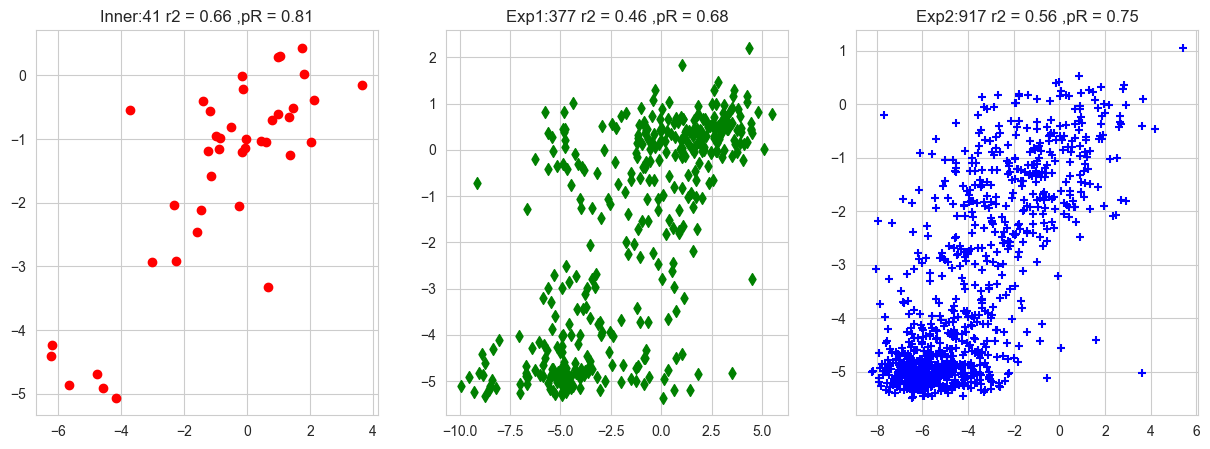

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sdf=e_test
plt.figure(figsize=(15,5))
for i in range(3):
    sdf = e_test[e_test["flag"]==i]
    plt.subplot(1,3,i+1)
    pr =  stats.pearsonr(sdf["score"],sdf["pred"])
    r = r2(sdf["score"],sdf["pred"])
    name = "Inner" if i==0 else "Exp1" if i==1 else "Exp2"
    marker = "o" if i==0 else "d" if i==1 else "+"
    color = "r" if i==0 else "g" if i==1 else "b"
    plt.title(f"{name}:{len(sdf)} r2 = {r:.2f} ,pR = {pr[0]:.2f}")
    plt.scatter(sdf["score"], sdf["pred"], marker=marker, color=color)
plt.show()


In [5]:
sdf

,seq,score,plasmid_counts,rna_counts,flag,distance,pred
2,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-3.523713,630,195,0,78,-4.072883
12,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-3.077781,218,100,0,79,-5.074340
105,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-6.073941,2556,113,0,77,-4.737756
107,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,0.629919,866,25844,0,77,-1.590886
122,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-5.243750,3338,579,0,77,-5.270149
125,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,0.216891,448,5109,0,79,-2.113942
142,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,1.668785,1162,57422,0,78,-0.679209
202,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-0.066345,354,7809,0,78,-1.251948
215,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,1.587296,105,4031,0,79,-1.350047
218,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-3.841257,66,20,0,78,-5.045916


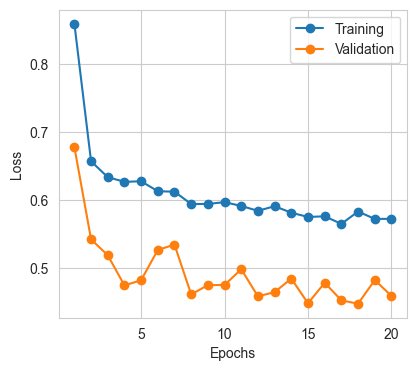

In [13]:
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import numpy
import scipy
import seaborn
# Plot training/validation losses
f, ax = pyplot.subplots(1, 1, figsize=(4.5, 4))
n_epochs_actual = len(pdf['loss'])

ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['loss'],
    marker='o',
    label='Training',
)
ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['val_loss'],
    marker='o',
    label='Validation',
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()